In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from IPython.core.display import HTML
import shutil


#dropout_rate = 0.5
#fc_dropout_rate = 0.5

dropout_rate = 0.6
fc_dropout_rate = 0.5

#dropout_rate = 0.6
#fc_dropout_rate = 0.4


DATA_DIR = f'results_009_gn_lang_classification__dropout_{dropout_rate}__fc_dropout_{fc_dropout_rate}'

model_names = ['LangIdCNN_Mean2_FCD']


# DATA_DIR = 'results_008_gn_lang_classification__dropout_0.6__fc_dropout_0.5_contrastive'
# model_names = ["LangIdCNN_Mean2_FCD_Contrastive", "LangIdCNN_Mean2_FCD"]



random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#7f7f7f", "#1f77b4"]

n = 84
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
data_frames = {}

variable_names = []

for model_path in Path(DATA_DIR).iterdir():
    if not model_path.is_dir():
        continue
        
    if "NN" not in str(model_path):
        continue
    
    model_name = model_path.stem
    print(f"MODEL: {model_name}")
    fold_names = []
    
    data_frames[model_name] = {}
    
    for p in Path(model_path).iterdir():
        if not p.suffixes or p.suffixes[-1] != '.csv':
            continue
        fold_name = p.stem
        fold_names.append(fold_name)
        data_frames[model_name][fold_name] = pd.read_csv(p)
        variable_names.extend(list(data_frames[model_path.stem][p.stem].columns))
    for fold_name in sorted(fold_names):
        print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
        
    

MODEL: LangIdCNN_Mean2_FCD
	retrained-wav2vec_features-c_0
	retrained-wav2vec_features-c_1
	retrained-wav2vec_features-c_2
	retrained-wav2vec_features-c_3
	retrained-wav2vec_features-c_4
	retrained-wav2vec_features-c_5
	retrained-wav2vec_features-c_6
	retrained-wav2vec_features-c_7
	retrained-wav2vec_features-c_8
	retrained-wav2vec_features-c_9
	retrained-wav2vec_features-z_0
	retrained-wav2vec_features-z_1
	retrained-wav2vec_features-z_2
	retrained-wav2vec_features-z_3
	retrained-wav2vec_features-z_4
	retrained-wav2vec_features-z_5
	retrained-wav2vec_features-z_6
	retrained-wav2vec_features-z_7
	retrained-wav2vec_features-z_8
	retrained-wav2vec_features-z_9
	wav2vec_features-c_0
	wav2vec_features-c_1
	wav2vec_features-c_2
	wav2vec_features-c_3
	wav2vec_features-c_4
	wav2vec_features-c_5
	wav2vec_features-c_6
	wav2vec_features-c_7
	wav2vec_features-c_8
	wav2vec_features-c_9
	wav2vec_features-z_0
	wav2vec_features-z_1
	wav2vec_features-z_2
	wav2vec_features-z_3
	wav2vec_features-z_4
	wa

In [3]:
def get_variable_stats(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum
    
        

In [4]:
def get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    for index, df in enumerate(selected_dfs):
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    return ep_best

def get_variable_stats(model_name, feature_prefix, variable, sample_size, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    #best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        #best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    #ep_best = np.argmax(best_epoch_selection_data, axis=0)
    ep_best = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [5]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable, sample_size):
    line_styles = ['-', '-']
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle=line_styles[index], label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [6]:
def plot_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}

    plot_width = len(model_names)*10
    plot_height = len(variables)*10
    fig, axes = plt.subplots(len(variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    axes = axes.reshape(len(variables), len(model_names))
    for variable_index, variable in enumerate(variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        sample_size = sample_sizes_by_variable[variable]
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index], # axes[variable_index]
                model_name,
                compared_features,
                variable,
                sample_size
            )

In [7]:
# def plot_best_results(model_names, variables_and_sample_sizes, model_selection_variable, compared_features):
    

In [8]:
fold_count = 10


# test_acc
# test_acc_channel_music
# test_acc_channel_noise
# test_acc_channel_telephone
# test_acc_gender_female
# test_acc_gender_male
# test_acc_language_maninka
# test_acc_language_pular
# test_acc_language_susu
# test_acc_speaker_count_multiple
# test_acc_speaker_count_single
# test_acc_utterance_multilingual
# test_acc_utterance_verbal_nod


    
#variables_and_sample_sizes = [
#    ('train_loss', n_train),
#    ('test_loss', n_test),
#    ('train_acc', n_train),
#    ('test_acc', n_test),
#    ('test_acc_gender_male', n_test),
#    ('test_acc_gender_female', n_test),
#    ('test_acc_language_maninka', n_test),
#    ('test_acc_language_pular', n_test),
#    ('test_acc_language_susu', n_test)
#]


variables_and_sample_sizes = [
    ('train_loss', fold_count),
    ('test_loss', fold_count),
    ('train_acc', fold_count),
    ('test_acc', fold_count),
    
    ('test_acc_gender_male', fold_count),
    ('test_acc_gender_female', fold_count),
    
    ('test_acc_language_maninka', fold_count),
    ('test_acc_language_pular', fold_count),
    ('test_acc_language_susu', fold_count),
    
    ('test_acc_speaker_count_multiple', fold_count),
    ('test_acc_speaker_count_single', fold_count),
    
    
    ('test_acc_utterance_multilingual', fold_count),
    ('test_acc_utterance_verbal_nod', fold_count),
    
    
    ('test_acc_channel_music', fold_count),
    ('test_acc_channel_noise', fold_count),
    ('test_acc_channel_telephone', fold_count),
    
    ('test_n', fold_count),
    ('test_n_channel_music', fold_count),
    ('test_n_channel_noise', fold_count),
    ('test_n_channel_telephone', fold_count),
    ('test_n_gender_female', fold_count),
    ('test_n_gender_male', fold_count),
    ('test_n_language_maninka', fold_count),
    ('test_n_language_pular', fold_count),
    ('test_n_language_susu', fold_count),
    ('test_n_speaker_count_multiple', fold_count),
    ('test_n_speaker_count_single', fold_count),
    ('test_n_utterance_multilingual', fold_count),
    ('test_n_utterance_verbal_nod', fold_count),

]


# Language classification with context features

In [9]:
#compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
#plot_results(model_names, variables_and_sample_sizes, compared_features)

# Language Classification With Latent Features

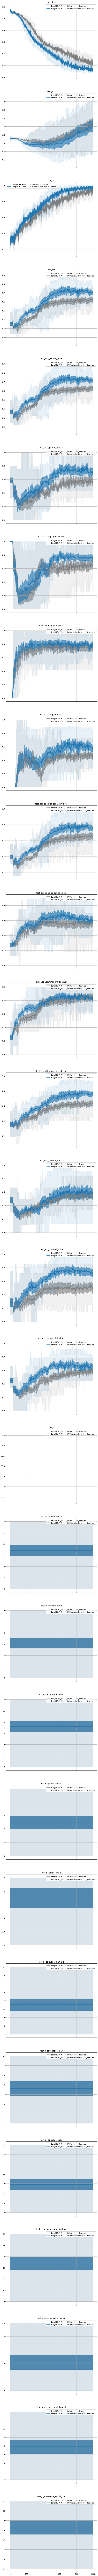

In [10]:
compared_features = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
plot_results(model_names, variables_and_sample_sizes, compared_features)

# Best epoch summaries

In [11]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [12]:
def plot_summary_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}
    
    series_means = {v:[] for v in variables}
    series_sems = {v:[] for v in variables}
    series_mins = {v:[] for v in variables}
    series_maxes = {v:[] for v in variables}
    
    series_labels = {v:[] for v in variables}
    
    for variable in variables:
        for feature_prefix in compared_features:
            sample_size = sample_sizes_by_variable[variable]
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
    
    for v in variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 20
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }

    
    #('test_acc_speaker_count_multiple', fold_count),
    #('test_acc_speaker_count_single', fold_count),
    
    
    #('test_acc_utterance_multilingual', fold_count),
    #('test_acc_utterance_verbal_nod', fold_count),
    
    
    #('test_acc_channel_music', fold_count),
    #('test_acc_channel_noise', fold_count),
    #('test_acc_channel_telephone', fold_count)
    

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    test_y_male_pos =(bar_width+bar_margin)*np.arange(label_count) + 3.5
    test_y_female_pos =(bar_width+bar_margin)*np.arange(label_count) + 4.5
    
    test_y_susu_pos =(bar_width+bar_margin)*np.arange(label_count) + 6
    test_y_maninka_pos =(bar_width+bar_margin)*np.arange(label_count) + 7
    test_y_pular_pos =(bar_width+bar_margin)*np.arange(label_count) + 8
    
    test_y_speaker_multi = (bar_width+bar_margin)*np.arange(label_count) + 9.5
    test_y_speaker_single = (bar_width+bar_margin)*np.arange(label_count) + 10.5
    
    test_y_utt_multilingual = (bar_width+bar_margin)*np.arange(label_count) + 12
    test_y_utt_verbal_nod = (bar_width+bar_margin)*np.arange(label_count) + 13
    
    test_y_channel_music = (bar_width+bar_margin)*np.arange(label_count) + 14.5
    test_y_channel_noise = (bar_width+bar_margin)*np.arange(label_count) + 15.5
    test_y_channel_telephone = (bar_width+bar_margin)*np.arange(label_count) + 16.5


    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    ax.barh(test_y_male_pos, series_means['test_acc_gender_male'], height=1, xerr=series_sems['test_acc_gender_male'], color=colors['male'], alpha=bias_alpha)
    ax.barh(test_y_female_pos, series_means['test_acc_gender_female'], height=1, xerr=series_sems['test_acc_gender_female'], color=colors['female'], alpha=bias_alpha)
    
    ax.barh(test_y_susu_pos, series_means['test_acc_language_susu'], height=1, xerr=series_sems['test_acc_language_susu'], color=colors['susu'], alpha=bias_alpha)
    ax.barh(test_y_maninka_pos, series_means['test_acc_language_maninka'], height=1, xerr=series_sems['test_acc_language_maninka'], color=colors['maninka'], alpha=bias_alpha)
    ax.barh(test_y_pular_pos, series_means['test_acc_language_pular'], height=1, xerr=series_sems['test_acc_language_pular'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_speaker_multi, series_means['test_acc_speaker_count_multiple'], height=1, xerr=series_sems['test_acc_speaker_count_multiple'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_speaker_single, series_means['test_acc_speaker_count_single'], height=1, xerr=series_sems['test_acc_speaker_count_single'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_utt_multilingual, series_means['test_acc_utterance_multilingual'], height=1, xerr=series_sems['test_acc_utterance_multilingual'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_utt_verbal_nod, series_means['test_acc_utterance_verbal_nod'], height=1, xerr=series_sems['test_acc_utterance_verbal_nod'], color=colors['pular'], alpha=bias_alpha)

    ax.barh(test_y_channel_music, series_means['test_acc_channel_music'], height=1, xerr=series_sems['test_acc_channel_music'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_noise, series_means['test_acc_channel_noise'], height=1, xerr=series_sems['test_acc_channel_noise'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_telephone, series_means['test_acc_channel_telephone'], height=1, xerr=series_sems['test_acc_channel_telephone'], color=colors['pular'], alpha=bias_alpha)

    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        

        
        ax.text(0.01, test_y_male_pos[i]-0.3, f"male ({series_means['test_n_gender_male'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_female_pos[i]-0.3, f"female ({series_means['test_n_gender_female'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_susu_pos[i]-0.3, f"susu ({series_means['test_n_language_susu'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_maninka_pos[i]-0.3, f"maninka ({series_means['test_n_language_maninka'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_pular_pos[i]-0.3, f"pular ({series_means['test_n_language_pular'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_speaker_multi[i]-0.3, f"multi speakers ({series_means['test_n_speaker_count_multiple'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_speaker_single[i]-0.3, f"single speaker ({series_means['test_n_speaker_count_single'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_utt_multilingual[i]-0.3, f"multi-lingual utt ({series_means['test_n_utterance_multilingual'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_utt_verbal_nod[i]-0.3, f"verbal nod utt ({series_means['test_n_utterance_verbal_nod'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_channel_music[i]-0.3, f"music ({series_means['test_n_channel_music'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_noise[i]-0.3, f"noise ({series_means['test_n_channel_noise'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_telephone[i]-0.3, f"telephone ({series_means['test_n_channel_telephone'][i]})", color='black', fontsize="small")
        
        
        ax.legend(["TRAIN", "TEST", "TEST (Male)", "TEST (Female)", "TEST (Susu)", "TEST (Maninka)", "TEST (Pular)"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n=10 folds) Language Identification Accuracies. Conv Dropout p={dropout_rate}. FC Dropout p={fc_dropout_rate}")
        ax.grid(True)

        
        


,train_loss_labels,train_loss_means,train_loss_sems
0,BSLN Latent - CNN_Mean2_FCD,0.447961,0.045827
1,OUR Latent - CNN_Mean2_FCD,0.258580,0.026440


,test_loss_labels,test_loss_means,test_loss_sems
0,BSLN Latent - CNN_Mean2_FCD,1.152507,0.113649
1,OUR Latent - CNN_Mean2_FCD,0.973931,0.112456


,train_acc_labels,train_acc_means,train_acc_sems
0,BSLN Latent - CNN_Mean2_FCD,0.794118,0.030660
1,OUR Latent - CNN_Mean2_FCD,0.921569,0.017094


,test_acc_labels,test_acc_means,test_acc_sems
0,BSLN Latent - CNN_Mean2_FCD,0.675758,0.021873
1,OUR Latent - CNN_Mean2_FCD,0.800000,0.026487


,test_acc_gender_male_labels,test_acc_gender_male_means,test_acc_gender_male_sems
0,BSLN Latent - CNN_Mean2_FCD,0.680847,0.020564
1,OUR Latent - CNN_Mean2_FCD,0.803931,0.024829


,test_acc_gender_female_labels,test_acc_gender_female_means,test_acc_gender_female_sems
0,BSLN Latent - CNN_Mean2_FCD,0.640794,0.037404
1,OUR Latent - CNN_Mean2_FCD,0.843849,0.064662


,test_acc_language_maninka_labels,test_acc_language_maninka_means,test_acc_language_maninka_sems
0,BSLN Latent - CNN_Mean2_FCD,0.708171,0.048073
1,OUR Latent - CNN_Mean2_FCD,0.820595,0.038960


,test_acc_language_pular_labels,test_acc_language_pular_means,test_acc_language_pular_sems
0,BSLN Latent - CNN_Mean2_FCD,0.786719,0.047357
1,OUR Latent - CNN_Mean2_FCD,0.854649,0.032024


,test_acc_language_susu_labels,test_acc_language_susu_means,test_acc_language_susu_sems
0,BSLN Latent - CNN_Mean2_FCD,0.537345,0.025888
1,OUR Latent - CNN_Mean2_FCD,0.731486,0.040779


,test_acc_speaker_count_multiple_labels,test_acc_speaker_count_multiple_means,test_acc_speaker_count_multiple_sems
0,BSLN Latent - CNN_Mean2_FCD,0.692960,0.019495
1,OUR Latent - CNN_Mean2_FCD,0.842639,0.031651


,test_acc_speaker_count_single_labels,test_acc_speaker_count_single_means,test_acc_speaker_count_single_sems
0,BSLN Latent - CNN_Mean2_FCD,0.664761,0.046157
1,OUR Latent - CNN_Mean2_FCD,0.716908,0.041387


,test_acc_utterance_multilingual_labels,test_acc_utterance_multilingual_means,test_acc_utterance_multilingual_sems
0,BSLN Latent - CNN_Mean2_FCD,0.895833,0.040409
1,OUR Latent - CNN_Mean2_FCD,0.937500,0.027163


,test_acc_utterance_verbal_nod_labels,test_acc_utterance_verbal_nod_means,test_acc_utterance_verbal_nod_sems
0,BSLN Latent - CNN_Mean2_FCD,0.672935,0.023170
1,OUR Latent - CNN_Mean2_FCD,0.822296,0.030233


,test_acc_channel_music_labels,test_acc_channel_music_means,test_acc_channel_music_sems
0,BSLN Latent - CNN_Mean2_FCD,0.589545,0.022347
1,OUR Latent - CNN_Mean2_FCD,0.694722,0.076278


,test_acc_channel_noise_labels,test_acc_channel_noise_means,test_acc_channel_noise_sems
0,BSLN Latent - CNN_Mean2_FCD,0.583571,0.065932
1,OUR Latent - CNN_Mean2_FCD,0.793571,0.053780


,test_acc_channel_telephone_labels,test_acc_channel_telephone_means,test_acc_channel_telephone_sems
0,BSLN Latent - CNN_Mean2_FCD,0.595758,0.028388
1,OUR Latent - CNN_Mean2_FCD,0.751364,0.042563


,test_n_labels,test_n_means,test_n_sems
0,BSLN Latent - CNN_Mean2_FCD,33.0,0.0
1,OUR Latent - CNN_Mean2_FCD,33.0,0.0


,test_n_channel_music_labels,test_n_channel_music_means,test_n_channel_music_sems
0,BSLN Latent - CNN_Mean2_FCD,9.4,0.493964
1,OUR Latent - CNN_Mean2_FCD,9.4,0.493964


,test_n_channel_noise_labels,test_n_channel_noise_means,test_n_channel_noise_sems
0,BSLN Latent - CNN_Mean2_FCD,7.1,0.457165
1,OUR Latent - CNN_Mean2_FCD,7.1,0.457165


,test_n_channel_telephone_labels,test_n_channel_telephone_means,test_n_channel_telephone_sems
0,BSLN Latent - CNN_Mean2_FCD,9.6,0.493964
1,OUR Latent - CNN_Mean2_FCD,9.6,0.493964


,test_n_gender_female_labels,test_n_gender_female_means,test_n_gender_female_sems
0,BSLN Latent - CNN_Mean2_FCD,6.5,0.474342
1,OUR Latent - CNN_Mean2_FCD,6.5,0.474342


,test_n_gender_male_labels,test_n_gender_male_means,test_n_gender_male_sems
0,BSLN Latent - CNN_Mean2_FCD,31.7,0.144914
1,OUR Latent - CNN_Mean2_FCD,31.7,0.144914


,test_n_language_maninka_labels,test_n_language_maninka_means,test_n_language_maninka_sems
0,BSLN Latent - CNN_Mean2_FCD,11.5,0.681909
1,OUR Latent - CNN_Mean2_FCD,11.5,0.681909


,test_n_language_pular_labels,test_n_language_pular_means,test_n_language_pular_sems
0,BSLN Latent - CNN_Mean2_FCD,11.6,0.764199
1,OUR Latent - CNN_Mean2_FCD,11.6,0.764199


,test_n_language_susu_labels,test_n_language_susu_means,test_n_language_susu_sems
0,BSLN Latent - CNN_Mean2_FCD,9.9,0.555878
1,OUR Latent - CNN_Mean2_FCD,9.9,0.555878


,test_n_speaker_count_multiple_labels,test_n_speaker_count_multiple_means,test_n_speaker_count_multiple_sems
0,BSLN Latent - CNN_Mean2_FCD,22.4,0.56921
1,OUR Latent - CNN_Mean2_FCD,22.4,0.56921


,test_n_speaker_count_single_labels,test_n_speaker_count_single_means,test_n_speaker_count_single_sems
0,BSLN Latent - CNN_Mean2_FCD,10.1,0.537587
1,OUR Latent - CNN_Mean2_FCD,10.1,0.537587


,test_n_utterance_multilingual_labels,test_n_utterance_multilingual_means,test_n_utterance_multilingual_sems
0,BSLN Latent - CNN_Mean2_FCD,7.9,0.817924
1,OUR Latent - CNN_Mean2_FCD,7.9,0.817924


,test_n_utterance_verbal_nod_labels,test_n_utterance_verbal_nod_means,test_n_utterance_verbal_nod_sems
0,BSLN Latent - CNN_Mean2_FCD,18.3,0.735527
1,OUR Latent - CNN_Mean2_FCD,18.3,0.735527


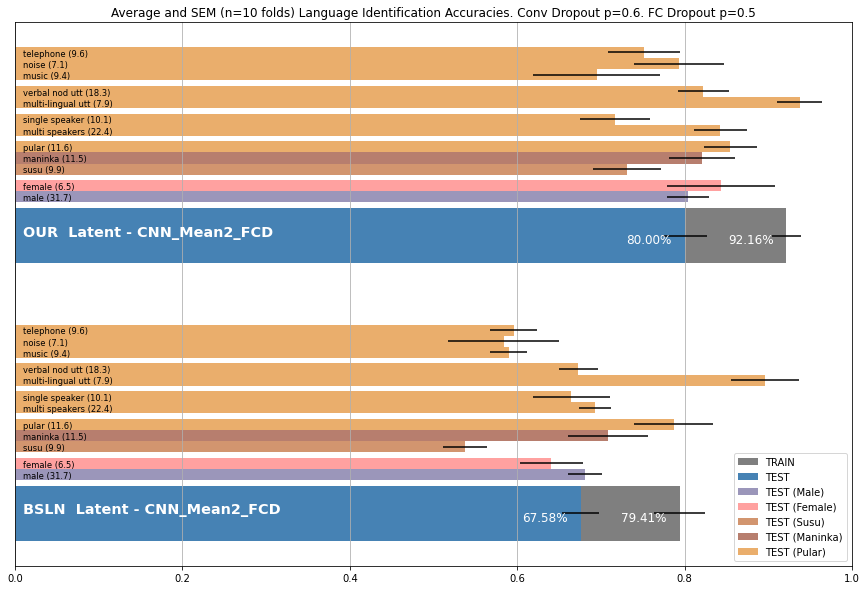

In [15]:
compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
compared_features_ctx = ['wav2vec_features-c', 'retrained-wav2vec_features-c']

for model_name in model_names:
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_latent)
    # plot_summary_results([model_name], variables_and_sample_sizes, compared_features_ctx)


In [55]:
import torch
import torch.nn as nn

In [56]:
class LangIdCNN_Mean2_FCD(nn.Module):
    def __init__(self):
        super(LangIdCNN_Mean2_FCD, self).__init__()
        
        self.conv0 = nn.Conv1d(in_channels=512, out_channels=3, kernel_size=1)
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3)
        self.drop1 = nn.Dropout(p=dropout_p)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3)
        self.drop2 = nn.Dropout(p=dropout_p)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3)
        self.drop3 = nn.Dropout(p=dropout_p)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3)
        self.drop4 = nn.Dropout(p=dropout_p)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.drop5 = nn.Dropout(p=fc_dropout_p)

        self.lin6 = nn.Linear(in_features=9, out_features=3)
        
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        x = self.conv0(x)
        
        x = self.conv1(x)
        x = F.elu(x)
        x = self.drop1(x)
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = F.elu(x)
        x = self.drop2(x)
        x = self.pool2(x)
        
        v1 = torch.mean(x, dim=2)
        
        x = self.conv3(x)
        x = F.elu(x)
        x = self.drop3(x)
        x = self.pool3(x)
        
        v2 = torch.mean(x, dim=2)
        
        x = self.conv4(x)
        x = F.elu(x)
        x = self.drop4(x)
        x = self.pool4(x)
        
        v3 = torch.mean(x, dim=2)
        
        v = torch.cat((v1, v2, v3), axis=1)
        v = self.drop5(v)
        
        x = self.lin6(v)
        
        return v, x

In [65]:
def load_best_models(feature_names):
    best_models = []

    for model_name in model_names:
        for feature_name in feature_names:
            best_epochs = get_best_epochs_per_fold(model_name, feature_name, best_epoch_selection_variable='test_acc')
            #print(f'{model_name} {feature_name} {best_epochs}')
            for fold_id, epoch in enumerate(best_epochs):
                checkpoint_path = f'{DATA_DIR}/{model_name}/{feature_name}_{fold_id}_checkpoints/{epoch:04}.pt'
                checkpoint_data = torch.load(checkpoint_path)
                # print(f'Loaded {checkpoint_path}')

                assert(epoch == checkpoint_data['epoch'])
                assert(fold_id == checkpoint_data['fold_id'])
                assert(feature_name == checkpoint_data['feature_name'])
                assert(model_name == checkpoint_data['model_name'])

                dropout_p = checkpoint_data['dropout_p']
                fc_dropout_p = checkpoint_data['fc_dropout_p']

                model_state_dict = checkpoint_data['model_state_dict']
                # optimizer_state_dict = checkpoint_data['optimizer_state_dict']

                model = LangIdCNN_Mean2_FCD()
                model.load_state_dict(model_state_dict)
                model.eval()

                best_models.append({
                    "feature_name": feature_name,
                    "fold_id": fold_id,
                    "model": model
                })
    return best_models
                

compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
best_models = load_best_models(compared_features_latent)
            
print(best_models)

[{'feature_name': 'wav2vec_features-z', 'fold_id': 0, 'model': LangIdCNN_Mean2_FCD(
  (conv0): Conv1d(512, 3, kernel_size=(1,), stride=(1,))
  (conv1): Conv1d(3, 1, kernel_size=(3,), stride=(1,))
  (drop1): Dropout(p=0.6, inplace=False)
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (drop2): Dropout(p=0.6, inplace=False)
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (drop3): Dropout(p=0.6, inplace=False)
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv4): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (drop4): Dropout(p=0.6, inplace=False)
  (pool4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (drop5): Dropout(p=0.5, inplace=False)
  (lin6): Linear(in_features=9, out_features=3, bias=True)
)}, {'feature_name': 'wav2vec_features-z', 'fold_id': 1, 'model': LangIdCNN_Mean2_FCD(
  (conv0): Conv1d(512, 3

In [70]:
len([m for m in best_models if m['feature_name'] == 'retrained-wav2vec_features-z'])

10